## Which citations are most frequenly issued in combination with other citations?

### For this analysis I have narrowed the 'Citations' dataset to only those citations that have been issued to the same person, on the same day, where more than one citation was issued.  A total of 902 observations meet this criteria.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import citations that have been issued to the same person, 
#on the same day, where more than one citation was issued
citations = '''
select *
from [dbo].[spd_PDCitations$] as A
inner join (select [Cited Person] as name2
			,[Cited Person Age] as age2
			,[Citation Date] as date2
			,concat([Cited Person],[Cited Person Age]) as unique_identifier
			,count(*) as count_of_citations
		   from [dbo].[spd_PDCitations$]
		   group by [Cited Person]
			,[Cited Person Age]
			,[Citation Date]
		   having count(*) >= '2'
		   ) as B on concat(A.[Cited Person],A.[Cited Person Age]) = B.unique_identifier
  '''
multiple_citations = pd.read_sql(citations, connection)
connection.close()

In [2]:
multiple_citations.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,Street,City,State,Zip,District,Beat,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,name2,age2,date2,unique_identifier,count_of_citations
0,629619.0,8092148.0,2018-09-02,1909.0,4-251A2,Liquor-Possess Open Container In Vehicle,CT,Criminal Traffic,826.0,7xxx,E Thomas Rd,Scottsdale,AZ,NaN,D1,2.0,709.0,"Hartman, Timothy",55.0,W,M,N,"Hartman, Timothy",55.0,2018-09-02,"Hartman, Timothy55",2
1,629661.0,2065108.0,2018-09-03,208.0,28-1381A1,DUI-Impaired to Slightest Degree,CT,Criminal Traffic,515.0,7xxx,E Indian School Rd,Scottsdale,AZ,NaN,D2,6.0,809.0,"Lofthouse, Garret",21.0,W,M,N,"Lofthouse, Garret",21.0,2018-09-03,"Lofthouse, Garret21",2
2,591099.0,2018203.0,2017-10-07,2237.0,28-1381A1,DUI-Impaired to Slightest Degree,CR,Criminal,1336.0,xxx,E Happy Valley Rd / N Scottsdale Rd,Scottsdale,AZ,NaN,D4,19.0,4001.0,"Abbott, JOy",57.0,W,F,N,"Abbott, JOy",57.0,2017-10-07,"Abbott, JOy57",2
3,591100.0,2018204.0,2017-10-07,2237.0,13-2906A1,Reckless Interference-Obstruct Highway-Public Thoroughfare,CR,Criminal,1336.0,xxx,E Happy Valley Rd / N Scottsdale Rd,Scottsdale,AZ,NaN,D4,19.0,4001.0,"Abbott, JOy",57.0,W,F,N,"Abbott, JOy",57.0,2017-10-07,"Abbott, JOy57",2
4,591104.0,2045406.0,2017-10-09,113.0,28-1381A1,DUI-Impaired to Slightest Degree,CT,Criminal Traffic,515.0,1xxx,N Miller Rd,Scottsdale,AZ,NaN,D1,3.0,406.0,"Armenta-Garcia, Ever",24.0,W,M,H,"Armenta-Garcia, Ever",24.0,2017-10-09,"Armenta-Garcia, Ever24",2


In [3]:
multiple_citations.shape

(902, 27)

In [4]:
# date range of citations based on the citation data I have currently downloaded

print('dataset dates range from' ,multiple_citations['Citation Date'].min(), 'to' ,multiple_citations['Citation Date'].max())

dataset dates range from 2017-09-23 00:00:00 to 2019-02-09 00:00:00


In [5]:
# concatenates all the citations for each person into a string within one column on one row for each person
multiple_citations_concat = multiple_citations \
    .groupby(['Cited Person'])['Charge Description'] \
    .apply(','.join) \
    .reset_index()

multiple_citations_concat.head(10)

,Cited Person,Charge Description
0,"Abbott, JOy","DUI-Impaired to Slightest Degree,Reckless Interference-Obstruct Highway-Public Thoroughfare,Speed Greater Than R&P or Posted"
1,"Acevedo, Jamie","F/Obey Police Officer,DUI-Impaired to Slightest Degree"
2,"Aguilar, Francina","Release of Vehicle Violation,Suspended/Revoked D.L."
3,"Aiello, Jacqueline","Prescription Drug-Possess/Use,DUI-Impaired to Slightest Degree"
4,"Akmal, Jasmine","Disorderly Conduct-Disruptive Behavior,Urinate/Defecate In Public"
5,"Anderson, Ernest","DUI-Impaired to Slightest Degree,Fail to Yield Turning Left at Intersection"
6,"Anderson, Goran","Driving In Bicycle Lane,DUI-Impaired to Slightest Degree"
7,"Anderson, Pamela","DUI-BAC of .08 or More,Following Too Close"
8,"Arellano, Rene","Criminal Damage-Deface,DUI-Impaired to Slightest Degree"
9,"Arguelles, Alain","Threat-Intim W/Inj-Dmge Prop,Expired/No Arizona Registration"


In [6]:
# function to do:
    # create list of citations for each Cited Person
    # sorts citations for each person
    # joins list of citations back together
def split_sort_func(cell):
    return ', '.join(sorted(cell.split(',')))

# apply above function to "Charge Description" column, then assign correctly sorted citations to "Split_Sort" column
multiple_citations_concat['Split_Sort'] = multiple_citations_concat['Charge Description'].apply(split_sort_func)

multiple_citations_concat.head(10)

,Cited Person,Charge Description,Split_Sort
0,"Abbott, JOy","DUI-Impaired to Slightest Degree,Reckless Interference-Obstruct Highway-Public Thoroughfare,Speed Greater Than R&P or Posted","DUI-Impaired to Slightest Degree, Reckless Interference-Obstruct Highway-Public Thoroughfare, Speed Greater Than R&P or Posted"
1,"Acevedo, Jamie","F/Obey Police Officer,DUI-Impaired to Slightest Degree","DUI-Impaired to Slightest Degree, F/Obey Police Officer"
2,"Aguilar, Francina","Release of Vehicle Violation,Suspended/Revoked D.L.","Release of Vehicle Violation, Suspended/Revoked D.L."
3,"Aiello, Jacqueline","Prescription Drug-Possess/Use,DUI-Impaired to Slightest Degree","DUI-Impaired to Slightest Degree, Prescription Drug-Possess/Use"
4,"Akmal, Jasmine","Disorderly Conduct-Disruptive Behavior,Urinate/Defecate In Public","Disorderly Conduct-Disruptive Behavior, Urinate/Defecate In Public"
5,"Anderson, Ernest","DUI-Impaired to Slightest Degree,Fail to Yield Turning Left at Intersection","DUI-Impaired to Slightest Degree, Fail to Yield Turning Left at Intersection"
6,"Anderson, Goran","Driving In Bicycle Lane,DUI-Impaired to Slightest Degree","DUI-Impaired to Slightest Degree, Driving In Bicycle Lane"
7,"Anderson, Pamela","DUI-BAC of .08 or More,Following Too Close","DUI-BAC of .08 or More, Following Too Close"
8,"Arellano, Rene","Criminal Damage-Deface,DUI-Impaired to Slightest Degree","Criminal Damage-Deface, DUI-Impaired to Slightest Degree"
9,"Arguelles, Alain","Threat-Intim W/Inj-Dmge Prop,Expired/No Arizona Registration","Expired/No Arizona Registration, Threat-Intim W/Inj-Dmge Prop"


In [7]:
# group by citation combination to determine counts
multiple_citations_ordered = multiple_citations_concat.groupby(['Split_Sort'])['Cited Person'] \
    .count() \
    .reset_index() \
    .sort_values('Cited Person', ascending=False)

multiple_citations_ordered.head(20)

,Split_Sort,Cited Person
105,"DUI-Impaired to Slightest Degree, No Proof of Insurance",21
84,"DUI-Impaired to Slightest Degree, Fail to Drive In A Single Lane",16
114,"DUI-Impaired to Slightest Degree, Speed Greater Than R&P or Posted",14
205,"Shoplifting-Removal of Goods, Shoplifting-Removal of Goods",12
99,"DUI-Impaired to Slightest Degree, Improper Right Turn Method",12
66,"DUI-Impaired to Slightest Degree, Driving In Bicycle Lane",11
92,"DUI-Impaired to Slightest Degree, Failure to Control Speed to Avoid A Collision",11
94,"DUI-Impaired to Slightest Degree, False Report to Law Enforcement",11
98,"DUI-Impaired to Slightest Degree, Improper Left Turn Method",9
89,"DUI-Impaired to Slightest Degree, Fail to Stop For Red Signal",9


### In most situations where multiple citations are issued a relatively minor infraction results in the person being pulled over, which creates the opportunity for assessment of a DUI citation along with a citation for whatever they did that originally got them pulled over.

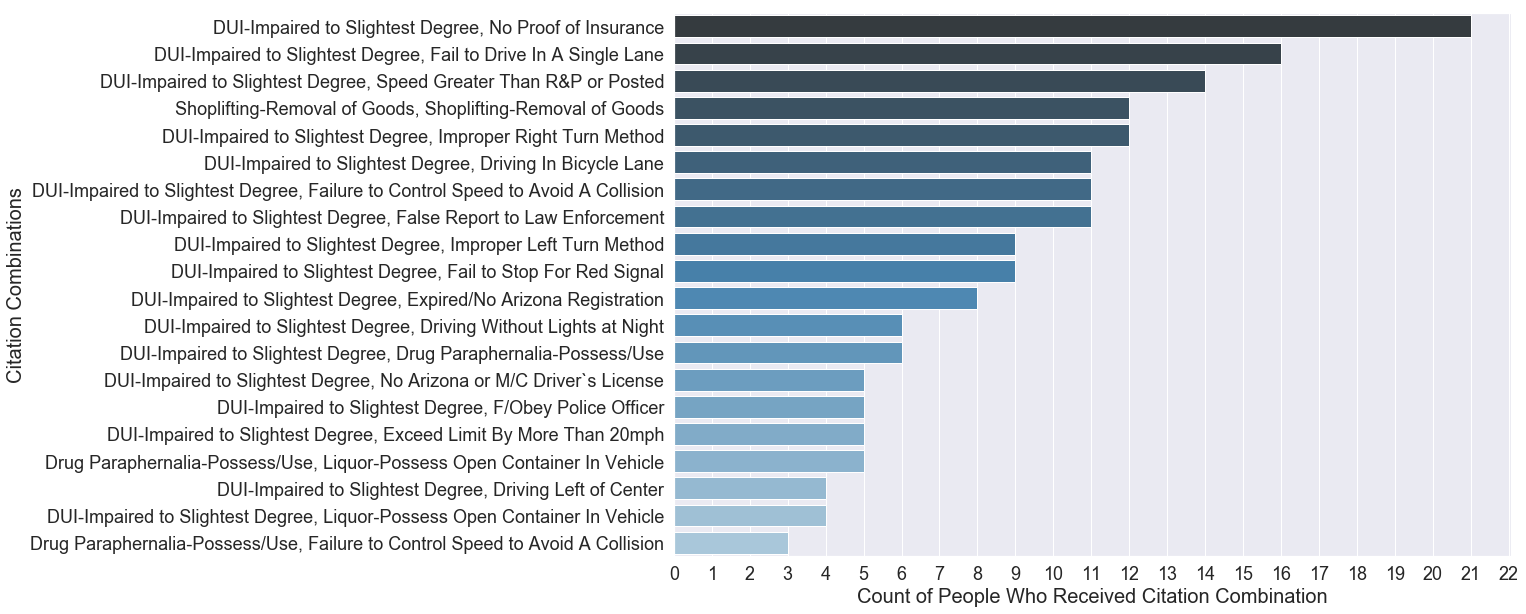

In [21]:
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.barplot(x=multiple_citations_ordered.iloc[:,1].head(20),\
                 y=multiple_citations_ordered.iloc[:,0].head(20),\
                palette="Blues_d")
plt.xlabel("Count of People Who Received Citation Combination",fontsize=20)
plt.ylabel("Citation Combinations",fontsize=20)
plt.tick_params(labelsize=18)
ax.xaxis.set_major_locator(ticker.MultipleLocator())
plt.savefig('visualizations/Multiple Citation Combinations.png',bbox_inches='tight')

### What about situations where more than two citations where issued to the same person at the same time?

#### Not much to show here.  Only one citation combination greater than two that was shared by more than one person.

In [9]:
# filter for cases where more than two citations where issued to the same person at the same time
more_than_two = multiple_citations.groupby(['Cited Person']).filter(lambda x: x['Charge Description'].count() > 2)

# concat on the Charge Description column
more_than_two_concat = more_than_two \
    .groupby(['Cited Person'])['Charge Description'] \
    .apply(','.join).reset_index()

def split_sort_func(cell):
    return ', '.join(sorted(cell.split(',')))

# apply above function to "Charge Description" column, then assign correctly sorted citations to "Split_Sort" column
more_than_two_concat['Split_Sort'] = more_than_two_concat['Charge Description'].apply(split_sort_func)

# group and sort data
more_than_two_concat = more_than_two_concat \
    .groupby(['Split_Sort'])['Cited Person'] \
    .count() \
    .reset_index() \
    .sort_values('Cited Person', ascending=False) \

more_than_two_concat.head()

,Split_Sort,Cited Person
27,"DUI-Impaired to Slightest Degree, No Proof of Insurance, Suspended/Revoked D.L.",2
0,"Accidents - Fail to Give Info-Name Add Etc., DUI-Impaired to Slightest Degree, False Report to Law Enforcement",1
37,"Exceed Limit By More Than 20mph, Reckless Driving, Speed Greater Than R&P or Posted, Speed Greater Than R&P or Posted, Speed Greater Than R&P or Posted, Suspended License For Failure to Appear/Pay",1
28,"DUI-Impaired to Slightest Degree, Reckless Interference-Obstruct Highway-Public Thoroughfare, Speed Greater Than R&P or Posted",1
29,"DUI-Impaired to Slightest Degree, Speed Greater Than R&P or Posted, Speed Greater Than R&P or Posted",1
